# Movie Studio Needs Analysis

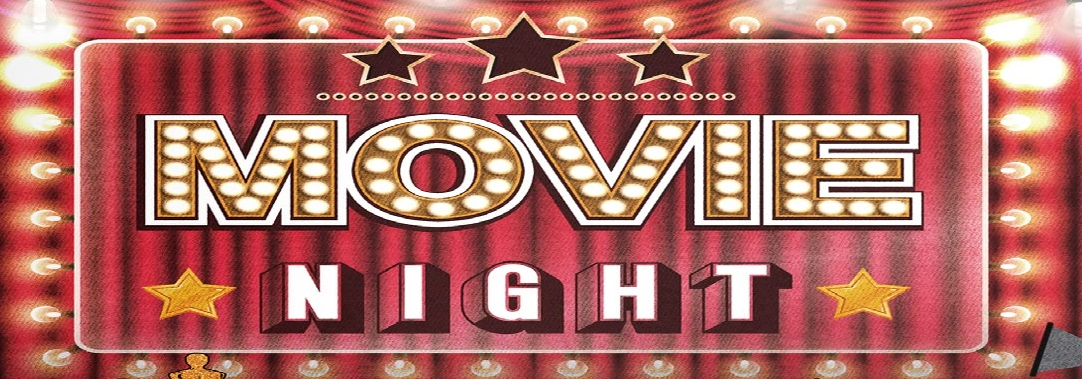

## Overview

This project analyzes the movie data from the Internet Movie Database (IMDB) in order to determine what types of films are doing the best at the box office.  A descriptive analysis of ...

## Business Understanding

Explain the business understanding...

## Data Understanding

IMDB is an online database of information related to films, television series, podcasts, home videos, video games, and streaming content online.  The data contains information including cast, production crew, plot summaries, trivia, ratings, and reviews.  Box Office Mojo is a website that tracks box-office revenue in a systematic, algorithmic way.  BLAH BLAH BLAH --> __ADD STUFF HERE__

In [125]:
#Import Necessary Libraries
import sqlite3
import pandas as pd
import plotly.express as px

#Connect to SQLLite3 Database
conn = sqlite3.connect('im.db')

In [126]:
#Load the CSV from Box Office Mojo
bom = pd.read_csv('bom.movie_gross.csv')

### Inspect the Contents of the Data

In [127]:
#Inspect the column names and the first 5 rows of data
bom.head()

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010

In [128]:
#See how many data entries there are
bom.shape

(3387, 5)

In [129]:
#See what dattypes the features are
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [ ]:
###foreign gross is missing 40% of its data so I'm going to drop that column and focus on domestic gross for this analysis
bom.drop(columns = ['foreign_gross'], inplace = True)

In [130]:
bom['domestic_gross'].describe()

count    3.359000e+03
mean     2.874585e+07
std      6.698250e+07
min      1.000000e+02
25%      1.200000e+05
50%      1.400000e+06
75%      2.790000e+07
max      9.367000e+08
Name: domestic_gross, dtype: float64

In [143]:
###foreign gross is missing 40% of its data so I'm going to drop that column and focus on domestic gross for this analysis
bom.drop(columns = ['foreign_gross'], inplace = True)

Bluebeard                      2
The Apparition (2018)          1
Margin Call                    1
Le Chef                        1
White Bird in a Blizzard       1
                              ..
Shame                          1
A Simple Life                  1
Beautiful Boy (2018)           1
The Three Musketeers (2011)    1
Silent House                   1
Name: title, Length: 3355, dtype: int64

In [146]:
#I inspect these rows and see that they are two separate movies made by two different studios in two different years so they aren't duplicates
bluebeard = bom[bom['title'] == 'Bluebeard']
print(bluebeard)

          title  studio  domestic_gross  year
317   Bluebeard  Strand         33500.0  2010
3045  Bluebeard   WGUSA         43100.0  2017


In [135]:
bom.isna().sum()

title              0
studio             5
domestic_gross    28
year               0
dtype: int64

In [147]:
#dropp the rows with missing values from studio and domestic gross which are important values for my analysis
bom.dropna(subset = ['studio', 'domestic_gross'], inplace = True)

In [148]:
bom.isna().sum()

title             0
studio            0
domestic_gross    0
year              0
dtype: int64

In [201]:
#Import CSV as a table in the db so that all the data is in one place
bom.to_sql('movie_gross', conn, if_exists='append', index=False)

## Data Analysis

In [150]:
q0 = """
SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.genres,
    mb.runtime_minutes,
    mr.averagerating
FROM
    movie_basics mb
    JOIN movie_ratings mr
        ON mb.movie_id = mr.movie_id
;
"""

pd.read_sql(q0, conn)

movie_id                    primary_title                genres  \
0      tt0063540                        Sunghursh    Action,Crime,Drama   
1      tt0066787  One Day Before the Rainy Season       Biography,Drama   
2      tt0069049       The Other Side of the Wind                 Drama   
3      tt0069204                  Sabse Bada Sukh          Comedy,Drama   
4      tt0100275         The Wandering Soap Opera  Comedy,Drama,Fantasy   
...          ...                              ...                   ...   
73851  tt9913084                 Diabolik sono io           Documentary   
73852  tt9914286                Sokagin Çocuklari          Drama,Family   
73853  tt9914642                        Albatross           Documentary   
73854  tt9914942       La vida sense la Sara Amat                  None   
73855  tt9916160                       Drømmeland           Documentary   

       runtime_minutes  averagerating  
0                175.0            7.0  
1                114.0            7.2  
2                122.0            6.9  
3                  NaN            6.1  
4                 80.0            6.5  
...                ...            ...  
73851             75.0            6.2  
73852             98.0            8.7  
73853              NaN            8.5  
73854              NaN            6.6  
73855             72.0            6.5  

[73856 rows x 5 columns]

In [151]:
q1 = """
SELECT 
    mb.genres,
    AVG(mr.averagerating) AS genre_ratings
FROM
    movie_basics mb
    JOIN movie_ratings mr
        ON mb.movie_id = mr.movie_id
GROUP BY mb.genres
ORDER BY genre_ratings DESC
LIMIT 5
;
"""

r2 = pd.read_sql(q1, conn)
r2

genres  genre_ratings
0  Comedy,Documentary,Fantasy            9.4
1  Documentary,Family,Musical            9.3
2               History,Sport            9.2
3               Music,Mystery            9.0
4                   Game-Show            9.0

In [152]:
fig1 = px.bar(r2, x='genre_ratings', y='genres', orientation = 'h', barmode='group', title='Top 5 Rated Movie Genres')
fig1.update_layout(yaxis={'categoryorder':'total ascending'})
fig1.show()

In [36]:
q2 = """
SELECT
    mb.runtime_minutes,
    mr.averagerating
FROM
    movie_basics mb
    JOIN movie_ratings mr
        ON mb.movie_id = mr.movie_id
WHERE runtime_minutes < 90
    GROUP BY runtime_minutes
;
"""

pd.read_sql(q2, conn)

runtime_minutes  averagerating
0               3.0            6.2
1               4.0            4.3
2               5.0            8.4
3               6.0            8.2
4               7.0            7.8
..              ...            ...
82             85.0            6.4
83             86.0            6.6
84             87.0            7.9
85             88.0            7.5
86             89.0            6.9

[87 rows x 2 columns]

In [65]:
q3 = """
SELECT
    studio,
    AVG(domestic_gross) AS average_domestic_gross
FROM movie_gross
GROUP BY studio
ORDER BY average_domestic_gross DESC
LIMIT 10

;
"""

r3 = pd.read_sql(q3, conn)
r3

studio  average_domestic_gross
0       BV            1.737644e+08
1     P/DW            1.682900e+08
2  WB (NL)            8.879333e+07
3     Uni.            8.777138e+07
4       WB            8.691461e+07
5      Fox            8.051103e+07
6     Sony            7.761177e+07
7     Par.            7.609773e+07
8      MGM            6.666667e+07
9     Sum.            6.212473e+07

In [69]:
fig3 = px.bar(r3, x = 'studio', y = 'average_domestic_gross', title = 'Income by Studio')
fig3.show()

In [194]:
q4 = """
SELECT
    mb.genres,
    AVG(mg.domestic_gross) as Average_Sales
FROM 
    movie_basics mb
    JOIN movie_gross mg
        ON mb.primary_title = mg.title
GROUP BY genres
ORDER BY Average_Sales DESC
LIMIT 10
;
"""

r4 = pd.read_sql(q4, conn)
r4


genres  Average_Sales
0     Adventure,Drama,Sport   4.007000e+08
1   Action,Adventure,Sci-Fi   2.345681e+08
2    Adventure,Drama,Sci-Fi   2.082000e+08
3   Documentary,Drama,Sport   2.067250e+08
4           Fantasy,Romance   2.005215e+08
5         Adventure,Fantasy   1.929000e+08
6   Biography,Drama,Musical   1.743000e+08
7  Action,Adventure,Mystery   1.509000e+08
8  Action,Adventure,Fantasy   1.412512e+08
9       Action,Drama,Family   1.310500e+08

In [192]:
fig4 = px.bar(r4, x='genres', y='Average_Sales', orientation = 'v', title='Average Movie Sales by Genre', hover_data=['genres'], color = 'genres' )
fig4.update_layout(xaxis={'categoryorder':'total descending'})
fig4.show()

In [86]:
q5 = """
SELECT 
    year,
    SUM(domestic_gross) AS Movie_Sales
FROM movie_gross
GROUP BY year
;
"""

r5 = pd.read_sql(q5, conn)
r5

year   Movie_Sales
0  2010  1.015693e+10
1  2011  1.006416e+10
2  2012  1.087661e+10
3  2013  1.079233e+10
4  2014  1.033774e+10
5  2015  1.105141e+10
6  2016  1.125365e+10
7  2017  1.093327e+10
8  2018  1.109121e+10

In [88]:
fig5 = px.line(r5, x='year', y='Movie_Sales', title = 'Movie Sales Over Time')
fig5.show()

In [113]:
q6 = """
SELECT 
    mb.runtime_minutes, 
    mr.averagerating
FROM
    movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
GROUP BY mb.runtime_minutes
HAVING mb.runtime_minutes < 90

;

"""

r6 = pd.read_sql(q6, conn)
r6

runtime_minutes  averagerating
0               3.0            6.2
1               4.0            4.3
2               5.0            8.4
3               6.0            8.2
4               7.0            7.8
..              ...            ...
82             85.0            6.4
83             86.0            6.6
84             87.0            7.9
85             88.0            7.5
86             89.0            6.9

[87 rows x 2 columns]

In [109]:
fig6 = px.histogram(r6, x='runtime_minutes', orientation ='v', title = 'Ratings by Movie Length', nbins=5)
fig6.show()

In [203]:
q7 = """
SELECT
    mb.primary_title, 
    mb.genres, 
    mg.domestic_gross
FROM
    movie_basics AS mb
        JOIN movie_gross AS mg
            ON mb.primary_title = mg.title
;
"""

r7 = pd.read_sql(q7, conn)
r7

primary_title                   genres  domestic_gross
0             Wazir       Action,Crime,Drama       1100000.0
1             Wazir       Action,Crime,Drama       1100000.0
2             Wazir       Action,Crime,Drama       1100000.0
3       On the Road  Adventure,Drama,Romance        744000.0
4       On the Road  Adventure,Drama,Romance        744000.0
...             ...                      ...             ...
10043      The Hunt                    Crime        613000.0
10044      The Hunt                    Crime        613000.0
10045   Unstoppable              Documentary      81600000.0
10046   Unstoppable              Documentary      81600000.0
10047   Unstoppable              Documentary      81600000.0

[10048 rows x 3 columns]

In [196]:
r7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   movie_id  146144 non-null  object
 1   genres    140736 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [216]:
r7[['Genre1', 'Genre2', 'Genre3']] = r7['genres'].str.split(',', expand = True)
r7

primary_title                   genres  domestic_gross      Genre1,  \
0             Wazir       Action,Crime,Drama       1100000.0       Action   
1             Wazir       Action,Crime,Drama       1100000.0       Action   
2             Wazir       Action,Crime,Drama       1100000.0       Action   
3       On the Road  Adventure,Drama,Romance        744000.0    Adventure   
4       On the Road  Adventure,Drama,Romance        744000.0    Adventure   
...             ...                      ...             ...          ...   
10043      The Hunt                    Crime        613000.0        Crime   
10044      The Hunt                    Crime        613000.0        Crime   
10045   Unstoppable              Documentary      81600000.0  Documentary   
10046   Unstoppable              Documentary      81600000.0  Documentary   
10047   Unstoppable              Documentary      81600000.0  Documentary   

      Genre2   Genre3       Genre1  
0      Crime    Drama       Action  
1      Crime    Drama       Action  
2      Crime    Drama       Action  
3      Drama  Romance    Adventure  
4      Drama  Romance    Adventure  
...      ...      ...          ...  
10043   None     None        Crime  
10044   None     None        Crime  
10045   None     None  Documentary  
10046   None     None  Documentary  
10047   None     None  Documentary  

[10048 rows x 7 columns]

<AxesSubplot:title={'center':'Sales By Genre'}, xlabel='Genre1,', ylabel='Sales'>

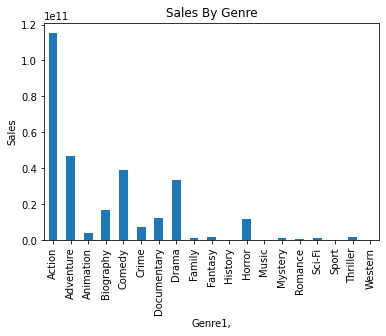

In [226]:
r7.groupby(['Genre1,'])['domestic_gross'].sum().plot.bar(ylabel = 'Sales', title = 'Sales By Genre')


In [235]:
fig7 = px.bar(r7, x='Genre1,', y='domestic_gross', orientation = 'v', title = 'Sales by Genre')
fig7.show()

In [176]:
q8 = """
SELECT
    REPLACE(genres, ',', ';') AS NewGenres
FROM
    movie_basics
;
"""

pd.read_sql(q8, conn)

NewGenres
0         Action;Crime;Drama
1            Biography;Drama
2                      Drama
3               Comedy;Drama
4       Comedy;Drama;Fantasy
...                      ...
146139                 Drama
146140           Documentary
146141                Comedy
146142                  None
146143           Documentary

[146144 rows x 1 columns]

In [237]:
q9 = """
SELECT
    mb.genres,
    mr.averagerating,
    mg.domestic_gross
FROM
    movie_gross AS mg
        JOIN movie_basics AS mb
            ON mg.title = mb.primary_title
                JOIN movie_ratings AS mr
                    ON mb.movie_id = mr.movie_id
;
"""

r9 = pd.read_sql(q9, conn)
r9

genres  averagerating  domestic_gross
0     Adventure,Animation,Comedy            8.3     415000000.0
1        Action,Adventure,Sci-Fi            8.8     292600000.0
2     Adventure,Animation,Comedy            6.3     238700000.0
3        Adventure,Drama,Fantasy            5.0     300500000.0
4        Action,Adventure,Sci-Fi            7.0     312400000.0
...                          ...            ...             ...
9030         Drama,Music,Romance            6.0         11400.0
9031              Comedy,Romance            5.9         11400.0
9032        Crime,Drama,Thriller            7.0          8900.0
9033       Action,Drama,Thriller            6.2          6200.0
9034                      Comedy            5.0          1700.0

[9035 rows x 3 columns]

In [243]:
fig9 = px.scatter(r9, x='averagerating', y='domestic_gross', trendline ='ols')
fig9.show()